In [33]:
train_test_splits = [
    (0.8, 0.2),  # 4:1
    (0.7, 0.3),  # 7:3
    (0.6, 0.4)   # 6:4
]

Tạo nhãn phân loại

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
# Load dataset
data = pd.read_csv('../data/raw/IBM_HR_Analytics.csv')
print("✓ Dataset loaded successfully!")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import json
import time

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully!")

# Load data
df = pd.read_csv('../data/processed/data_normalized.csv')
print(f"✓ Data loaded: {df.shape}")

# Load metadata
with open('../data/processed/metadata.json', 'r') as f:
    metadata = json.load(f)

target_col = metadata['target_column']
print(f"✓ Target variable: {target_col}")

# Separate features and target
y = df[target_col].values
X = df.drop(target_col, axis=1).values
feature_names = df.drop(target_col, axis=1).columns.tolist()

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {len(feature_names)}")

✓ Libraries imported successfully!
Pandas version: 2.0.3
NumPy version: 1.24.3
✓ Dataset loaded successfully!
✓ Libraries imported successfully!
✓ Data loaded: (1470, 48)
✓ Target variable: JobSatisfaction

Features shape: (1470, 47)
Target shape: (1470,)
Number of features: 47


In [35]:

# Chia JobSatisfaction thành các bins
# Dựa vào phân cụm hoặc quantile
df['JobSatisfaction_Category'] = pd.cut(
    df['JobSatisfaction'],
    bins=[0, 2, 3, 5],  # Low (1-2), Medium (3), High (4-5)
    labels=['Low', 'Medium', 'High']
)

# Hoặc dùng quantile để cân bằng số lượng mẫu
df['JobSatisfaction_Category'] = pd.qcut(
    df['JobSatisfaction'],
    q=3,
    labels=['Low', 'Medium', 'High']
)

print("Phân phối nhãn:")
print(df['JobSatisfaction_Category'].value_counts())

# Encode labels
le_target = LabelEncoder()
y_class = le_target.fit_transform(df['JobSatisfaction_Category'])

Phân phối nhãn:
JobSatisfaction_Category
Low       569
High      459
Medium    442
Name: count, dtype: int64


Phân loại với nhiều mô hình

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Lưu kết quả classification
results_classification = {
    'split': [],
    'model': [],
    'data_type': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}
print("Creating PCA reduced features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of components (explained variance > 95%)
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.argmax(cumsum_variance >= 0.95) + 1
n_components = max(3, min(n_components, X.shape[1] // 2))  # At least 3, at most half

pca = PCA(n_components=n_components, random_state=42)
X_pca_reduced = pca.fit_transform(X_scaled)
def train_and_evaluate_classification(X_train, X_test, y_train, y_test,
                                     model_name, data_type, split_ratio):
    """Train and evaluate classification model"""

    models = {
        'Naive Bayes': GaussianNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'SVM': SVC(kernel='rbf', random_state=42)
    }

    model = models[model_name]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results_classification['split'].append(split_ratio)
    results_classification['model'].append(model_name)
    results_classification['data_type'].append(data_type)
    results_classification['accuracy'].append(accuracy)
    results_classification['precision'].append(precision)
    results_classification['recall'].append(recall)
    results_classification['f1'].append(f1)

    return model, y_pred

# Chạy experiments
for train_size, test_size in train_test_splits:
    split_ratio = f"{int(train_size*10)}:{int(test_size*10)}"

    # Dữ liệu gốc
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_class, test_size=test_size, random_state=42
    )

    for model_name in ['Naive Bayes', 'Logistic Regression', 'Decision Tree', 'SVM']:
        train_and_evaluate_classification(
            X_train, X_test, y_train, y_test,
            model_name, 'Original', split_ratio
        )

    # Dữ liệu giảm chiều
    X_train_pca, X_test_pca, y_train, y_test = train_test_split(
        X_pca_reduced, y_class, test_size=test_size, random_state=42
    )

    for model_name in ['Naive Bayes', 'Logistic Regression', 'Decision Tree', 'SVM']:
        train_and_evaluate_classification(
            X_train_pca, X_test_pca, y_train, y_test,
            model_name, 'PCA_Reduced', split_ratio
        )

# Hiển thị kết quả
results_class_df = pd.DataFrame(results_classification)
print("\\n=== KẾT QUẢ PHÂN LOẠI ===")
print(results_class_df.to_string())

Creating PCA reduced features...
\n=== KẾT QUẢ PHÂN LOẠI ===
   split                model    data_type  accuracy  precision    recall        f1
0    8:2          Naive Bayes     Original  0.333333   0.337195  0.333333  0.333042
1    8:2  Logistic Regression     Original  0.360544   0.347541  0.360544  0.346975
2    8:2        Decision Tree     Original  0.367347   0.359157  0.367347  0.360923
3    8:2                  SVM     Original  0.363946   0.328912  0.363946  0.321638
4    8:2          Naive Bayes  PCA_Reduced  0.350340   0.340537  0.350340  0.340661
5    8:2  Logistic Regression  PCA_Reduced  0.346939   0.313265  0.346939  0.308964
6    8:2        Decision Tree  PCA_Reduced  0.350340   0.348151  0.350340  0.348797
7    8:2                  SVM  PCA_Reduced  0.374150   0.364447  0.374150  0.334019
8    7:3          Naive Bayes     Original  0.360544   0.356884  0.360544  0.356901
9    7:3  Logistic Regression     Original  0.371882   0.363964  0.371882  0.350170
10   7:3       

 Confusion Matrix

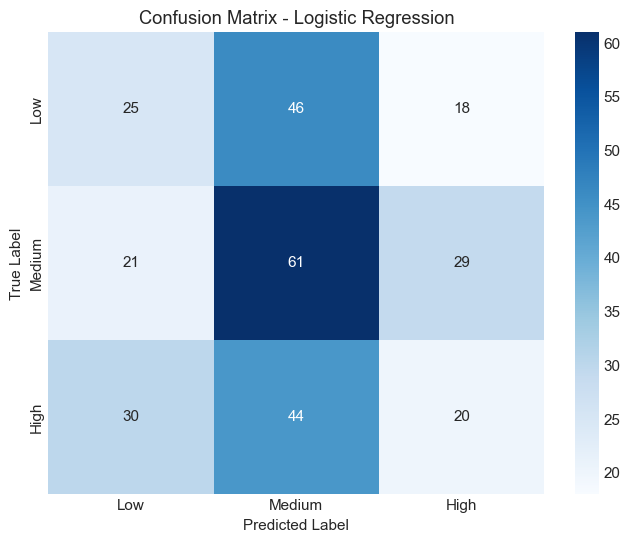

\n=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         Low       0.33      0.28      0.30        89
      Medium       0.40      0.55      0.47       111
        High       0.30      0.21      0.25        94

    accuracy                           0.36       294
   macro avg       0.34      0.35      0.34       294
weighted avg       0.35      0.36      0.35       294



In [37]:
from sklearn.metrics import confusion_matrix, classification_report

# Vẽ confusion matrix cho model tốt nhất
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

best_clf = LogisticRegression(max_iter=1000, random_state=42)
best_clf.fit(X_train, y_train)
y_pred_class = best_clf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_class,
                          target_names=['Low', 'Medium', 'High']))